In [1]:
# -*- coding: utf-8 -*-
"""NTK.ipynb

Automatically generated by Colab.

Original file is located at
    """

#!pip install nbconvert
#!pip install transformers
#!pip install datasets

#%cd PEFT
#%ls

import torch
from transformers import AutoModel, AutoTokenizer, BertForSequenceClassification
from functorch import jacrev, make_functional_with_buffers
import gc
from torch import nn
from torch.nn.functional import relu
from torch.autograd import grad

import numpy as np
import torch
from datasets import load_dataset#, load_metric
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from torch.utils.data import Dataset
import logging

from datasets import load_dataset

raw_datasets  = load_dataset("glue", 'sst2')

from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoConfig, AutoModelForSequenceClassification
#from roberta import RobertaForSequenceClassification


model_name = "bert-base-uncased"
#model_name = prajjwal1/bert-mini
#config.num_labels=2
tokenizer = AutoTokenizer.from_pretrained(model_name)

from transformers import AutoTokenizer, DataCollatorWithPadding
def preprocessing_function(examples):
    return tokenizer(examples['sentence'], truncation=True, max_length=128)


tokenized_datasets = raw_datasets.map(preprocessing_function, batched=True)
# llama_tokenized_datasets = llama_tokenized_datasets.rename_column("target", "label")
tokenized_datasets.set_format("torch")

# Data collator for padding a batch of examples to the maximum length seen in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Commented out IPython magic to ensure Python compatibility.
import torch
import torch.nn as nn
from transformers import RobertaForSequenceClassification
from transformers.activations import ACT2FN
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'



model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# %ls

# Commented out IPython magic to ensure Python compatibility.
# %cd PEFT
import leader

leader.PEFT(model, method='row', targets=['classifier'], rank=1)
#targets=['key', 'value', 'dense', 'query'])
# method = 'row', 'column', 'random'

#import evaluate
import numpy as np
from sklearn import metrics
import torch
import numpy as np

def compute_metrics(eval_pred):


    logits, labels = eval_pred # eval_pred is the tuple of predictions and labels returned by the model
    predictions = np.argmax(logits, axis=-1)

    #precision = metrics.precision_score(labels, predictions, average="macro")
    #recall = metrics.recall_score(labels, predictions, average="macro")
    #f1 = metrics.f1_score(labels, predictions, average="macro")
    accuracy = metrics.accuracy_score(labels, predictions)
    return {'accuracy': accuracy}
    #return {"precision": precision, "recall": recall, "f1-score": f1, 'accuracy': accuracy}

from transformers import TrainingArguments, Trainer

import time
from transformers import Trainer, TrainingArguments

tokenized_datasets["validation"]['sentence'][0:10]



def Kernal_Whole(tensor):
    # Get the dimensions of the input tensor
    N, M, P, Q = tensor.shape

    result_tensor = tensor.permute(0, 2, 1, 3).reshape(N * P, M * Q)

    return result_tensor

# Function to tokenize input text
def tokenize_input(texts, tokenizer, max_length=10):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Example input sets
texts_set_1 = tokenized_datasets["validation"]['sentence'][0:40]
texts_set_2 = tokenized_datasets["validation"]['sentence'][40:80]


# Tokenize inputs
input_set_1 = tokenize_input(texts_set_1, tokenizer)
input_set_2 = tokenize_input(texts_set_2, tokenizer)

# Move inputs to the same device as the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_set_1 = {k: v.to(device) for k, v in input_set_1.items()}
input_set_2 = {k: v.to(device) for k, v in input_set_2.items()}
model = model.to(device)

import torch
from transformers import BertForSequenceClassification, BertTokenizer
import torch.nn as nn
from functorch import make_functional_with_buffers, vmap, jacrev


# Get word embeddings instead of text input
def get_word_embeddings(input_ids):
    with torch.no_grad():
        outputs = model.bert.embeddings(input_ids)
    return outputs

# We will focus on the last layer output
class BertLastLayer(nn.Module):
    def __init__(self, bert_model):
        super(BertLastLayer, self).__init__()
        self.bert_model = bert_model

    def forward(self, embeddings):
        # Get the last hidden states from BERT
        outputs = self.bert_model(inputs_embeds=embeddings)
        # We are only interested in the last hidden state
        last_hidden_state = outputs.logits
        return last_hidden_state  # CLS token's representation for simplicity

# Example usage:

bert_last_layer = BertLastLayer(model).to(device)

# Example sentence
sentence = ["hello", 'world']

# Tokenize the sentence
#inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True).to(device)
input_ids_train = input_set_1['input_ids']

# Get word embeddings for the sentence
x_train = get_word_embeddings(input_ids_train)

input_ids_test = input_set_2['input_ids']

# Get word embeddings for the sentence
x_test = get_word_embeddings(input_ids_test)

# Convert the BERT model to a functional model using functorch, including buffers
fnet, params, buffers = make_functional_with_buffers(bert_last_layer)

# Function for a single pass through the functional model
def fnet_single(params, buffers, x):
    return fnet(params, buffers, x.unsqueeze(0)).squeeze(0)

# NTK Calculation (similar to your original code)
def empirical_ntk_jacobian_contraction(fnet_single, params, buffers, x1, x2, compute='full'):
    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, None, 0))(params, buffers, x1)
    jac1 = [j.flatten(2) for j in jac1]
    print('params',len(params))
    print('buffers',len(buffers))

    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, None, 0))(params, buffers, x2)
    jac2 = [j.flatten(2) for j in jac2]

    # Compute J(x1) @ J(x2).T
    einsum_expr = None
    if compute == 'full':
        einsum_expr = 'Naf,Mbf->NMab'
    elif compute == 'trace':
        einsum_expr = 'Naf,Maf->NM'
    elif compute == 'diagonal':
        einsum_expr = 'Naf,Maf->NMa'
    else:
        assert False

    result = torch.stack([torch.einsum(einsum_expr, j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result








/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/_functorch/deprecated.py:104: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional_with_buffers is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.fu

In [2]:
# Compute NTK
result_from_ntk_vps = empirical_ntk_jacobian_contraction(fnet_single, params, buffers, x_train, x_test,compute='full')
print(result_from_ntk_vps.shape)
ntk_result = Kernal_Whole(result_from_ntk_vps)
print(ntk_result.shape)



/opt/conda/lib/python3.10/site-packages/torch/_functorch/deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/opt/conda/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/opt/conda/lib/python3.10/site-pa

params 201
buffers 3
torch.Size([40, 40, 2, 2])
torch.Size([80, 80])


----pretain NTK done---------


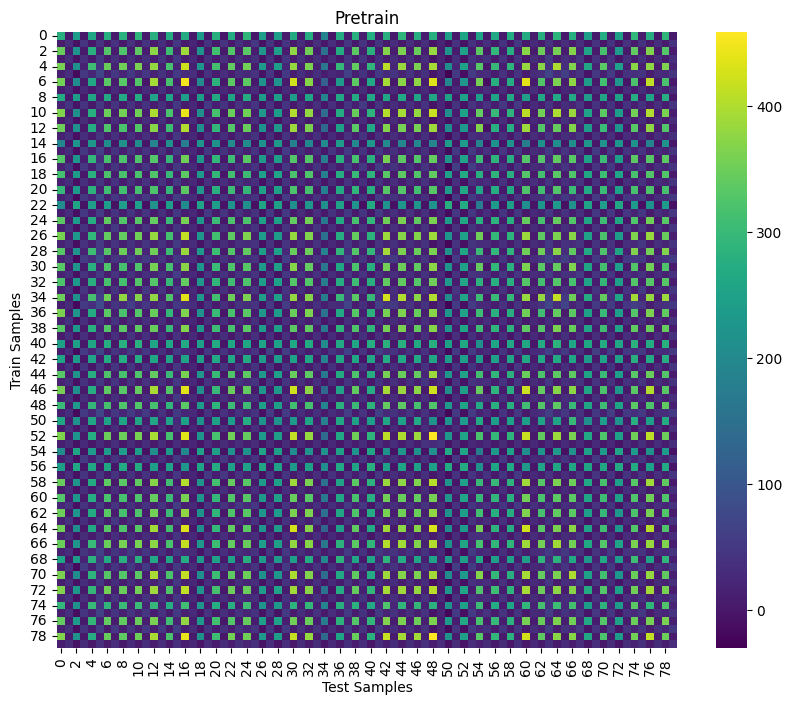

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


result_ntk_np_pre = ntk_result.detach().cpu().numpy()  # Convert to CPU and NumPy

# Use seaborn's heatmap function to plot
plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(result_ntk_np_pre, cmap="viridis")  # You can change the color map to 'coolwarm', 'magma', etc.
plt.title("Heatmap of NTK")
plt.xlabel("Test Samples")
plt.ylabel("Train Samples")
plt.title('Pretrain')

plt.savefig('NTK_pretrain.jpg', format='jpg', dpi=300)
print("----pretain NTK done---------")
plt.show()


In [4]:
import pickle
import numpy as np

# Save the array to a file
with open('pretrain.pkl', 'wb') as f:
    pickle.dump(result_ntk_np_pre, f)


In [4]:

# Count of trainable parameters
total_trainable_params = 0
total =  0
# Print trainable parameters and count their total number
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}, Shape: {param.shape}")
        
        total_trainable_params += param.numel()
    total+=param.numel()

print(f"Total trainable parameters:{total_trainable_params}, percentage:  {total_trainable_params/total}")

Parameter name: classifier.trainable_weight, Shape: torch.Size([1, 768])
Parameter name: classifier.bias, Shape: torch.Size([2])
Total trainable parameters:770, percentage:  7.033054717805073e-06


In [7]:
!pwd

/


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
trainer.save_model("dir")

In [5]:
#train one epoch

num_samples = len(tokenized_datasets["train"])
steps_per_epoch = num_samples // 32  # Assuming batch size is 32
max_steps_half_epoch = steps_per_epoch // 2
max_steps=max_steps_half_epoch

training_args = TrainingArguments(
    output_dir='dir',
    learning_rate=2e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.00,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    save_steps=10000000,
    logging_steps=100,

    load_best_model_at_end=True,
    lr_scheduler_type="cosine",  # You can choose from 'linear', 'cosine', 'cosine_with_restarts', 'polynomial', etc.
    warmup_steps=100,
    #max_steps=max_steps_half_epoch  # Train for half epoch
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],

    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.703100,0.655172,0.643349
200,0.647500,0.718753,0.521789
300,0.629300,0.577305,0.739679
400,0.593900,0.555083,0.782110
500,0.580000,0.537989,0.748853
600,0.571100,0.556033,0.690367
700,0.542800,0.562569,0.669725
800,0.533900,0.515173,0.748853
900,0.528200,0.492652,0.793578
1000,0.536400,0.523797,0.708716


TrainOutput(global_step=6315, training_loss=0.5091766801412768, metrics={'train_runtime': 187.0105, 'train_samples_per_second': 1080.405, 'train_steps_per_second': 33.768, 'total_flos': 4176618788254428.0, 'train_loss': 0.5091766801412768, 'epoch': 3.0})

In [6]:
#plot heat map
result_from_ntk_vps = empirical_ntk_jacobian_contraction(fnet_single, params, buffers, x_train, x_test,compute='full')
ntk_result = Kernal_Whole(result_from_ntk_vps)

result_ntk_np = ntk_result.detach().cpu().numpy()  # Convert to CPU and NumPy


/opt/conda/lib/python3.10/site-packages/torch/_functorch/deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/opt/conda/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/opt/conda/lib/python3.10/site-pa

OutOfMemoryError: CUDA out of memory. Tried to allocate 720.00 MiB. GPU 0 has a total capacity of 79.33 GiB of which 701.81 MiB is free. Process 1808940 has 78.63 GiB memory in use. Of the allocated memory 78.12 GiB is allocated by PyTorch, and 15.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


# Use seaborn's heatmap function to plot
plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(result_ntk_np, cmap="viridis")  # You can change the color map to 'coolwarm', 'magma', etc.
plt.title("Heatmap of NTK")
plt.xlabel("Test Samples")
plt.ylabel("Train Samples")
plt.title('Epoch 1')
plt.savefig('NTK_one_epoch.jpg', format='jpg', dpi=300)
print("----one epoch NTK done---------")
plt.show()

NameError: name 'result_ntk_np' is not defined

<Figure size 1000x800 with 0 Axes>

In [5]:
type(result_ntk_np)

numpy.ndarray

In [3]:
!huggingface-cli scan-cache

REPO ID                  REPO TYPE SIZE ON DISK NB FILES LAST_ACCESSED LAST_MODIFIED REFS LOCAL PATH                                                     
------------------------ --------- ------------ -------- ------------- ------------- ---- -------------------------------------------------------------- 
meta-llama/Llama-2-7b-hf model            13.5G        9 24 hours ago  1 week ago    main /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-hf 

Done in 0.0s. Scanned 1 repo(s) for a total of 13.5G.
Got 1 warning(s) while scanning. Use -vvv to print details.


In [4]:
!huggingface-cli delete-cache

Traceback (most recent call last):
  File "/opt/conda/bin/huggingface-cli", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/huggingface_hub/commands/huggingface_cli.py", line 52, in main
    service.run()
  File "/opt/conda/lib/python3.10/site-packages/huggingface_hub/commands/delete_cache.py", line 138, in run
    selected_hashes = _manual_review_tui(hf_cache_info, preselected=[])
  File "/opt/conda/lib/python3.10/site-packages/huggingface_hub/commands/delete_cache.py", line 87, in _inner
    raise ImportError(
ImportError: The `delete-cache` command requires extra dependencies to work with the TUI.
Please run `pip install huggingface_hub[cli]` to install them.
Otherwise, disable TUI using the `--disable-tui` flag.


In [5]:
!pip show transformers

Name: transformers
Version: 4.44.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /opt/conda/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft


In [2]:
!pip install seaborn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.1 MB/s eta 0:00:00


In [7]:
!huggingface-cli cache list


usage: huggingface-cli <command> [<args>]
huggingface-cli: error: argument {download,upload,repo-files,env,login,whoami,logout,repo,lfs-enable-largefiles,lfs-multipart-upload,scan-cache,delete-cache,tag}: invalid choice: 'cache' (choose from 'download', 'upload', 'repo-files', 'env', 'login', 'whoami', 'logout', 'repo', 'lfs-enable-largefiles', 'lfs-multipart-upload', 'scan-cache', 'delete-cache', 'tag')


In [8]:
!huggingface-cli cache delete


usage: huggingface-cli <command> [<args>]
huggingface-cli: error: argument {download,upload,repo-files,env,login,whoami,logout,repo,lfs-enable-largefiles,lfs-multipart-upload,scan-cache,delete-cache,tag}: invalid choice: 'cache' (choose from 'download', 'upload', 'repo-files', 'env', 'login', 'whoami', 'logout', 'repo', 'lfs-enable-largefiles', 'lfs-multipart-upload', 'scan-cache', 'delete-cache', 'tag')


In [11]:
!ls ~/.cache/huggingface


datasets  hub  modules	token


In [12]:
!echo $HF_HOME


In [13]:
!rm -rf ~/.cache/huggingface


In [8]:
result_ntk_np_pre.shape, result_ntk_np.shape

((80, 80), (80, 80))

In [1]:
import numpy as np
import pickle
import numpy as np
# Load the array from the file
with open('pretrain.pkl', 'rb') as f:
    result_ntk_np_pre = pickle.load(f)

with open('leader.pkl', 'rb') as f:
    result_ntk_np = pickle.load(f)

# Calculate the Frobenius norm (distance between the two matrices)
frobenius_norm = np.linalg.norm(result_ntk_np_pre - result_ntk_np, 'fro')

frobenius_norm


1283.0105

----one epoch NTK done---------


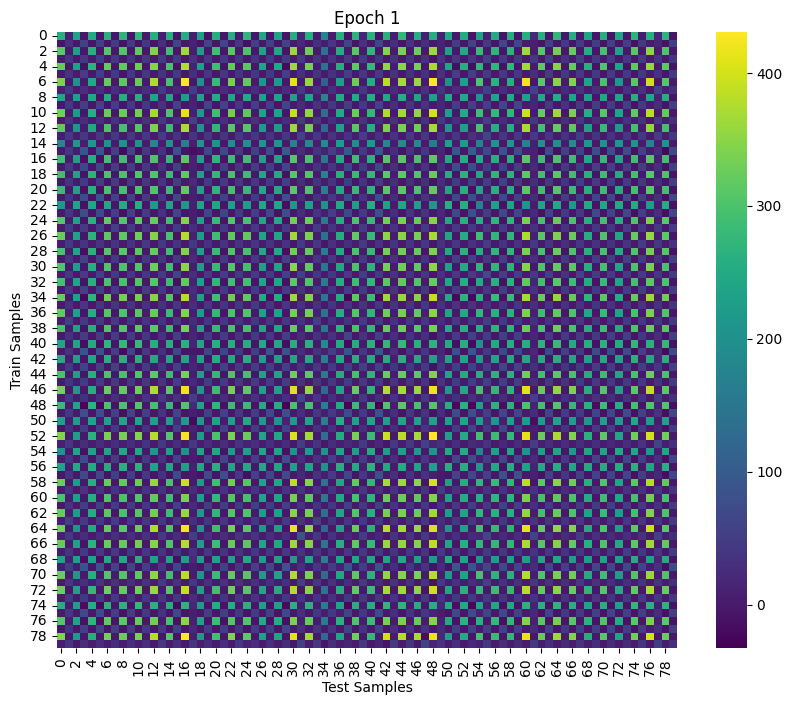

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


# Use seaborn's heatmap function to plot
plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(result_ntk_np, cmap="viridis")  # You can change the color map to 'coolwarm', 'magma', etc.
plt.title("Heatmap of NTK")
plt.xlabel("Test Samples")
plt.ylabel("Train Samples")
plt.title('Epoch 1')
plt.savefig('NTK_one_epoch.jpg', format='jpg', dpi=300)
print("----one epoch NTK done---------")
plt.show()

----pretain NTK done---------


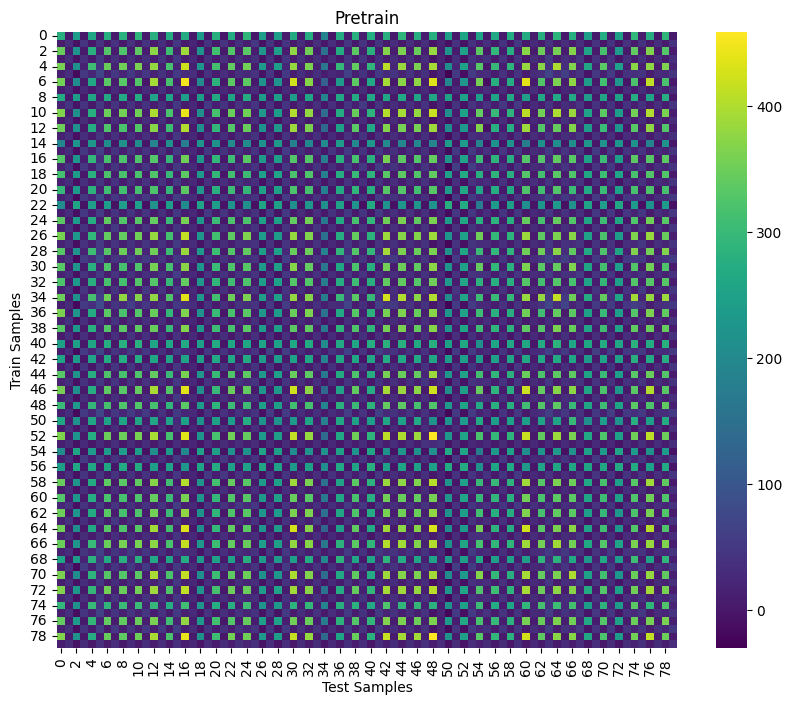

In [3]:
# Use seaborn's heatmap function to plot
plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(result_ntk_np_pre, cmap="viridis")  # You can change the color map to 'coolwarm', 'magma', etc.
plt.title("Heatmap of NTK")
plt.xlabel("Test Samples")
plt.ylabel("Train Samples")
plt.title('Pretrain')

plt.savefig('NTK_pretrain.jpg', format='jpg', dpi=300)
print("----pretain NTK done---------")
plt.show()
